# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Read-Tags" data-toc-modified-id="Read-Tags-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read Tags</a></div><div class="lev1 toc-item"><a href="#Read-Posts" data-toc-modified-id="Read-Posts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Read Posts</a></div><div class="lev1 toc-item"><a href="#Read-post-parquet" data-toc-modified-id="Read-post-parquet-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Read post parquet</a></div><div class="lev1 toc-item"><a href="#Read-Tags-xml" data-toc-modified-id="Read-Tags-xml-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Read Tags xml</a></div><div class="lev1 toc-item"><a href="#Join-post-and-tag" data-toc-modified-id="Join-post-and-tag-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Join post and tag</a></div>

# Dataset

stackoverflow datascience 7zip stored at [Archive.org](https://archive.org/download/stackexchange/datascience.stackexchange.com.7z)

Download the 7zip file and decompress the xml files inside the folder called `datascience`.

# Imports

In [1]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
sns.set()
sns.set_style('darkgrid')

In [2]:
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.dot import dot_graph
from dask.diagnostics import ProgressBar

In [13]:
import re
import html
from datetime import datetime

In [15]:
%load_ext watermark

%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
json       2.0.9
re         2.2.1
autopep8   1.4
pandas     0.23.4
matplotlib 3.0.1
numpy      1.15.4
dask       1.1.1
seaborn    0.9.0



# Read Tags

In [18]:
tags_xml = db.read_text('datascience//Tags.xml', encoding='utf-8')

In [19]:
lst = [attr for attr in dir(tags_xml) if attr[0].islower() ]
lst = np.array_split(lst,5)
pd.DataFrame(lst).T

,0,1,2,3,4
0,accumulate,fold,mean,reduction,to_avro
1,all,foldby,min,remove,to_dataframe
2,any,frequencies,name,repartition,to_delayed
3,compute,groupby,npartitions,starmap,to_textfiles
4,count,join,persist,std,topk
5,dask,map,pluck,str,unzip
6,distinct,map_partitions,product,sum,var
7,filter,max,random_sample,take,visualize
8,flatten,None,None,None,None


In [20]:
tags_xml.take(10)

('\ufeff<?xml version="1.0" encoding="utf-8"?>\n',
 '<tags>\n',
 '  <row Id="1" TagName="definitions" Count="22" ExcerptPostId="105" WikiPostId="104" />\n',
 '  <row Id="2" TagName="machine-learning" Count="4497" ExcerptPostId="4909" WikiPostId="4908" />\n',
 '  <row Id="3" TagName="bigdata" Count="343" ExcerptPostId="66" WikiPostId="65" />\n',
 '  <row Id="5" TagName="data-mining" Count="782" ExcerptPostId="80" WikiPostId="79" />\n',
 '  <row Id="6" TagName="databases" Count="56" ExcerptPostId="8960" WikiPostId="8959" />\n',
 '  <row Id="8" TagName="libsvm" Count="12" ExcerptPostId="18" WikiPostId="17" />\n',
 '  <row Id="10" TagName="scalability" Count="23" />\n',
 '  <row Id="11" TagName="efficiency" Count="26" ExcerptPostId="142" WikiPostId="141" />\n')

In [21]:
# we need only lines with word rows

In [22]:
tags_rows = tags_xml.filter(lambda line: line.find('<row') >= 0)
tags_rows.take(10)

('  <row Id="1" TagName="definitions" Count="22" ExcerptPostId="105" WikiPostId="104" />\n',
 '  <row Id="2" TagName="machine-learning" Count="4497" ExcerptPostId="4909" WikiPostId="4908" />\n',
 '  <row Id="3" TagName="bigdata" Count="343" ExcerptPostId="66" WikiPostId="65" />\n',
 '  <row Id="5" TagName="data-mining" Count="782" ExcerptPostId="80" WikiPostId="79" />\n',
 '  <row Id="6" TagName="databases" Count="56" ExcerptPostId="8960" WikiPostId="8959" />\n',
 '  <row Id="8" TagName="libsvm" Count="12" ExcerptPostId="18" WikiPostId="17" />\n',
 '  <row Id="10" TagName="scalability" Count="23" />\n',
 '  <row Id="11" TagName="efficiency" Count="26" ExcerptPostId="142" WikiPostId="141" />\n',
 '  <row Id="12" TagName="performance" Count="84" />\n',
 '  <row Id="13" TagName="nosql" Count="20" ExcerptPostId="119" WikiPostId="118" />\n')

In [23]:
def extract_column_value(line, col_name, cast_type=str):
    # TagName=".net"  ==> .net  when column is TagName
    pattern_tpl = r'{col}="([^"]*)"'
    pattern = pattern_tpl.format(col=col_name)
    match = re.search(pattern, line)

    if cast_type == int:
        null_value = 0  # numpy does not have nans for ints, make it zero
    else:
        null_value = None

    return cast_type(match[1]) if match is not None else null_value

In [24]:
test_tags_row = '<row Id="1" TagName=".net" Count="257092" ExcerptPostId="3624959" WikiPostId="3607476" />'
print(extract_column_value(test_tags_row, 'TagName'))
print(extract_column_value(test_tags_row, 'TagName'))
print(extract_column_value(test_tags_row, 'NotHere', str))
print(extract_column_value(test_tags_row, 'NotHere', int))

.net
.net
None
0


In [ ]:
def extract_tags_columns(line):
    row = {
        'id': extract_column_value(line, 'Id', int),
        'tag_name': extract_column_value(line, 'TagName', str),
        'count': extract_column_value(line, 'Count', int),
    }
    return row

In [27]:
test_tags_row = '<row Id="1" TagName=".net" Count="257092" ExcerptPostId="3624959" WikiPostId="3607476" />'

extract_tags_columns(test_tags_row)

{'id': 1, 'tag_name': '.net', 'count': 257092}

In [28]:
# now, get dask dataframes
# to_dataframe makes pandas dataframe.
tags = tags_rows.map(extract_tags_columns).to_dataframe()
tags

,count,id,tag_name
npartitions=1,,,
,int64,int64,object
,...,...,...


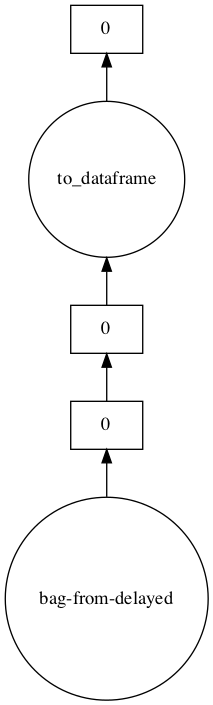

In [29]:
tags.visualize()

In [32]:
# after building graph, compute
# now, its panads! enjoy the calculations.
tags_df = tags.compute()
print(type(tags_df))
tags_df.head()

<class 'pandas.core.frame.DataFrame'>


,count,id,tag_name
0,22,1,definitions
1,4497,2,machine-learning
2,343,3,bigdata
3,782,5,data-mining
4,56,6,databases


# Read Posts

In [34]:
posts_xml = db.read_text('datascience/Posts.xml', encoding='utf-8', blocksize=1e8)
posts_xml

dask.bag<bag-fro..., npartitions=1>

In [37]:
posts_xml.take(5)

('\ufeff<?xml version="1.0" encoding="utf-8"?>\r\n',
 '<posts>\r\n',
 '  <row Id="5" PostTypeId="1" CreationDate="2014-05-13T23:58:30.457" Score="9" ViewCount="480" Body="&lt;p&gt;I\'ve always been interested in machine learning, but I can\'t figure out one thing about starting out with a simple &quot;Hello World&quot; example - how can I avoid hard-coding behavior?&lt;/p&gt;&#xA;&#xA;&lt;p&gt;For example, if I wanted to &quot;teach&quot; a bot how to avoid randomly placed obstacles, I couldn\'t just use relative motion, because the obstacles move around, but I don\'t want to hard code, say, distance, because that ruins the whole point of machine learning.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;Obviously, randomly generating code would be impractical, so how could I do this?&lt;/p&gt;&#xA;" OwnerUserId="5" LastActivityDate="2014-05-14T00:36:31.077" Title="How can I do simple machine learning without hard-coding behavior?" Tags="&lt;machine-learning&gt;" AnswerCount="1" CommentCount="1" FavoriteCo

In [38]:
# filter only the rows
posts_rows = posts_xml.filter(lambda line: line.find('<row') >= 0)

posts_rows.take(5)

('  <row Id="5" PostTypeId="1" CreationDate="2014-05-13T23:58:30.457" Score="9" ViewCount="480" Body="&lt;p&gt;I\'ve always been interested in machine learning, but I can\'t figure out one thing about starting out with a simple &quot;Hello World&quot; example - how can I avoid hard-coding behavior?&lt;/p&gt;&#xA;&#xA;&lt;p&gt;For example, if I wanted to &quot;teach&quot; a bot how to avoid randomly placed obstacles, I couldn\'t just use relative motion, because the obstacles move around, but I don\'t want to hard code, say, distance, because that ruins the whole point of machine learning.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;Obviously, randomly generating code would be impractical, so how could I do this?&lt;/p&gt;&#xA;" OwnerUserId="5" LastActivityDate="2014-05-14T00:36:31.077" Title="How can I do simple machine learning without hard-coding behavior?" Tags="&lt;machine-learning&gt;" AnswerCount="1" CommentCount="1" FavoriteCount="1" ClosedDate="2014-05-14T14:40:25.950" />\r\n',
 '  <row Id="7"

In [39]:
# deal with timestamp
def str_to_datetime(timestamp):
    f = '%Y-%m-%dT%H:%M:%S.%f'
    return datetime.strptime(timestamp, f)

str_to_datetime('2008-07-31T23:55:37.967')

datetime.datetime(2008, 7, 31, 23, 55, 37, 967000)

In [40]:
def extract_posts_columns(line):
    l = html.unescape(line)
    row = {
        'id': extract_column_value(l, 'Id', int),
        'creation_date': extract_column_value(l, 'CreationDate', str_to_datetime),
        'score': extract_column_value(l, 'Score', int),
        'view_count': extract_column_value(l, 'ViewCount', int),
        'tags': extract_column_value(l, 'Tags', str),
    }
    return row

In [41]:
test_posts_row = '  <row Id="4" PostTypeId="1" AcceptedAnswerId="7" CreationDate="2008-07-31T21:42:52.667" Score="506" ViewCount="32399" Body="&lt;p&gt;I want to use a track-bar to change a form\'s opacity.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;This is my code:&lt;/p&gt;&#xA;&#xA;&lt;pre&gt;&lt;code&gt;decimal trans = trackBar1.Value / 5000;&#xA;this.Opacity = trans;&#xA;&lt;/code&gt;&lt;/pre&gt;&#xA;&#xA;&lt;p&gt;When I build the application, it gives the following error:&lt;/p&gt;&#xA;&#xA;&lt;blockquote&gt;&#xA;  &lt;p&gt;Cannot implicitly convert type \'decimal\' to \'double\'.&lt;/p&gt;&#xA;&lt;/blockquote&gt;&#xA;&#xA;&lt;p&gt;I tried using &lt;code&gt;trans&lt;/code&gt; and &lt;code&gt;double&lt;/code&gt; but then the control doesn\'t work. This code worked fine in a past VB.NET project. &lt;/p&gt;&#xA;" OwnerUserId="8" LastEditorUserId="126970" LastEditorDisplayName="Rich B" LastEditDate="2017-03-10T15:18:33.147" LastActivityDate="2017-03-10T15:18:33.147" Title="While applying opacity to a form should we use a decimal or double value?" Tags="&lt;c#&gt;&lt;winforms&gt;&lt;type-conversion&gt;&lt;decimal&gt;&lt;opacity&gt;" AnswerCount="13" CommentCount="5" FavoriteCount="37" CommunityOwnedDate="2012-10-31T16:42:47.213" />\n'
extract_posts_columns(test_posts_row)

{'id': 4,
 'creation_date': datetime.datetime(2008, 7, 31, 21, 42, 52, 667000),
 'score': 506,
 'view_count': 32399,
 'tags': '<c#><winforms><type-conversion><decimal><opacity>'}

In [42]:
# skip all the posts without tags.
posts = posts_rows.map(extract_posts_columns)\
    .filter(lambda r: r['tags'] is not None)\
    .to_dataframe()
posts

,creation_date,id,score,tags,view_count
npartitions=1,,,,,
,datetime64[ns],int64,int64,object,int64
,...,...,...,...,...


In [43]:
posts.head()

,creation_date,id,score,tags,view_count
0,2014-05-13 23:58:30.457,5,9,<machine-learning>,480
1,2014-05-14 00:11:06.457,7,4,<education><open-source>,400
2,2014-05-14 01:25:59.677,14,21,<data-mining><definitions>,1309
3,2014-05-14 01:41:23.110,15,2,<databases>,567
4,2014-05-14 01:57:56.880,16,18,<machine-learning><bigdata><libsvm>,329


In [47]:
# after cleaning xml, write data to a more suitable parquet format.
with ProgressBar():
    posts.repartition(npartitions=100)\
        .to_parquet('datascience/posts_tags.parq', engine='fastparquet', compression='GZIP')

[########################################] | 100% Completed |  2.7s


# Read post parquet

In [48]:
posts = dd.read_parquet('datascience/posts_tags.parq', engine='fastparquet')
posts

,creation_date,id,score,tags,view_count
npartitions=100,,,,,
,datetime64[ns],int64,int64,object,int64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [50]:
# yearly posts
with ProgressBar():
    posts_count = posts.groupby(posts.creation_date.dt.year)\
        .id.count()\
        .to_frame()\
        .rename(columns={'id': 'count'})\
        .compute()
posts_count

[########################################] | 100% Completed |  0.9s


,count
creation_date,
2014,562
2015,1176
2016,2203
2017,3153
2018,6455


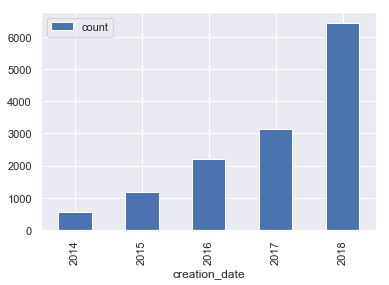

In [51]:
posts_count.plot.bar();

In [52]:
# faster method
with ProgressBar():
    posts_count = posts.creation_date.dt.year.value_counts()\
    .to_frame()\
    .rename(columns={'creation_date': 'count'})\
    .compute()
posts_count

[########################################] | 100% Completed |  0.7s


,count
2018,6455
2017,3153
2016,2203
2015,1176
2014,562


In [53]:
# 1. since parquet files are much much smaller than csv we can use pandas.
# 2. dask gives multiple parquet files, one per partition, we need to combine
#    them to use in pandas since pandas load only one parquet.
#
# 3. we can also create pandas df directly from xml above, without writing to
#    parquet and then reading from parquet, but resulting pandas dataframe
#    will be much large (maybe 2GB) and jupyter kernels may die because of
#    large object. e.g. when code completion.
#
#   WHEN USING BIG OBJECTS, do not use CODE-COMPLETION!!! 

In [54]:
posts = posts.set_index('id')
posts.head(2)

,creation_date,score,tags,view_count
id,,,,
5,2014-05-13 23:58:30.457,9,<machine-learning>,480
7,2014-05-14 00:11:06.457,4,<education><open-source>,400


In [55]:
type(posts)

dask.dataframe.core.DataFrame

In [56]:
posts_count = posts.creation_date.dt.date.value_counts()
posts_count

Dask Series Structure:
npartitions=1
    int64
      ...
Name: creation_date, dtype: int64
Dask Name: value-counts-agg, 616 tasks

In [58]:
with ProgressBar():
    posts_count_df = posts_count.compute()

posts_count_df.head()

[########################################] | 100% Completed |  1.1s


2018-11-28    45
2018-04-23    35
2018-05-23    35
2018-08-07    33
2018-02-21    33
Name: creation_date, dtype: int64

In [65]:
type(posts_count_df)

pandas.core.series.Series

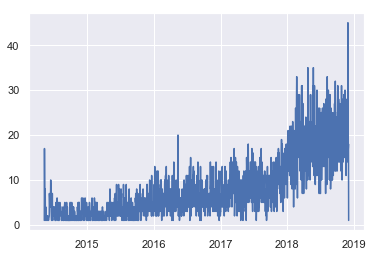

In [59]:
posts_count_df.plot();

In [60]:
# daily data looks messy, make it smoother using monthly resampling

In [61]:
# to deal with timeseries, alway make index timeseries

In [62]:
posts_count_df.index = pd.DatetimeIndex(posts_count_df.index)

In [63]:
posts_by_month = posts_count_df.resample('MS').sum()\
    .rename('count').to_frame()
posts_by_month.head()

,count
2014-05-01,58
2014-06-01,99
2014-07-01,76
2014-08-01,65
2014-09-01,48


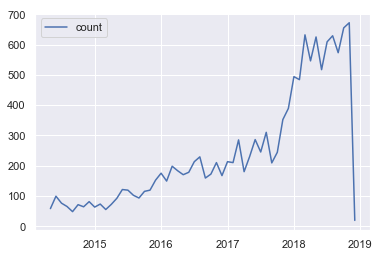

In [66]:
posts_by_month.plot();

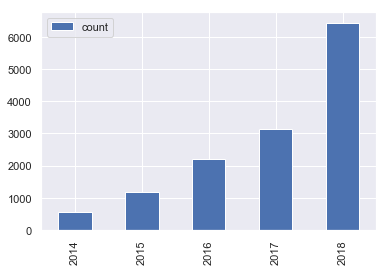

In [67]:
# yearly plot
posts_count_df.groupby(posts_count_df.index.year).sum()\
.rename('count').to_frame().plot.bar();

# Read Tags xml

In [69]:
tags = db.read_text('datascience/Tags.xml')\
    .filter(lambda l: l.find('<row') > 0)\
    .map(extract_tags_columns)\
    .to_dataframe()\
    .set_index('tag_name')\
    .compute()

print(tags.shape)
tags.head(10)

(422, 2)


,count,id
tag_name,,
.net,6,62
ab-test,30,344
accuracy,101,101
activation-function,43,564
active-learning,5,483
activity-recognition,1,680
actor-critic,7,584
aggregation,17,284
ai,8,614


In [71]:
langs = ['c', 'c++', 'c#', 'java', 'javascript', 'python', 'r']
tags.loc[tags.index.isin(langs), :]

,count,id
tag_name,,
c,7,286
java,48,179
javascript,17,73
python,2210,46
r,883,24


In [72]:
posts.head()

,creation_date,score,tags,view_count
id,,,,
5,2014-05-13 23:58:30.457,9,<machine-learning>,480
7,2014-05-14 00:11:06.457,4,<education><open-source>,400
14,2014-05-14 01:25:59.677,21,<data-mining><definitions>,1309
15,2014-05-14 01:41:23.110,2,<databases>,567
16,2014-05-14 01:57:56.880,18,<machine-learning><bigdata><libsvm>,329


In [73]:
post_tags = posts.tags.str.lower()\
    .str.extractall('<([^>]*)>')\
    .rename(columns={0: 'tag'})
post_tags.head()

tag
id match                  
5  0      machine-learning
7  0             education
   1           open-source
14 0           data-mining
   1           definitions

In [ ]:
# persist keep data in RAM
with ProgressBar():
    post_known_tags = post_tags.where(post_tags.tag.isin(langs))\
        .dropna().persist()

In [74]:
post_known_tags.head()

[########################################] | 100% Completed |  2.1s


,,tag
id,match,
41,1,r
50,0,r
52,0,r
59,1,r
116,2,python


In [ ]:
# since we have data in RAM, this takes much small time.
with ProgressBar():
    known_tags_count = post_known_tags.tag.value_counts().to_frame().compute()

In [75]:
known_tags_count

[########################################] | 100% Completed |  0.2s


,tag
python,2210
r,883
java,48
javascript,17
c,7


# Join post and tag

In [84]:
posts.head(2)

,creation_date,score,tags,view_count
id,,,,
5,2014-05-13 23:58:30.457,9,<machine-learning>,480
7,2014-05-14 00:11:06.457,4,<education><open-source>,400


In [85]:
post_known_tags.head(2)

,,tag
id,match,
41,1,r
50,0,r


In [90]:
post_tag_join = (posts.join(post_known_tags, how='inner')
                 # timestamp 2014-05-14 11:15:40.907 ==> 2014-05-14 string format
                 .assign(creation_date = lambda df: df.creation_date.dt.date)
                 # object ==> category
                 .assign(tag = lambda df: df.tag.astype('category')))

post_tag_join

,creation_date,score,tags,view_count,tag
npartitions=100,,,,,
5,object,int64,object,int64,category[unknown]
554,...,...,...,...,...
...,...,...,...,...,...
41714,...,...,...,...,...
41956,...,...,...,...,...


In [91]:
with ProgressBar():
    post_tag_join = post_tag_join.persist()

[########################################] | 100% Completed |  2.0s


In [89]:
post_tag_join.head()

,,creation_date,score,tags,view_count,tag
id,match,,,,,
41,1,2014-05-14 11:15:40.907,43,<bigdata><r>,4883,r
50,0,2014-05-14 14:26:54.313,6,<r><databases><efficiency><tools>,520,r
52,0,2014-05-14 15:25:21.700,33,<r><data-cleaning>,3141,r
59,1,2014-05-14 17:48:21.240,10,<apache-hadoop><r>,992,r
116,2,2014-05-17 09:16:18.823,26,<machine-learning><dimensionality-reduction><p...,2720,python


In [86]:
post_tag_join.dtypes

creation_date      object
score               int64
tags               object
view_count          int64
tag              category
dtype: object

In [98]:
# languages vs creation date pivot table
post_tag_join['tag'] = post_tag_join['tag'].cat.as_known()
post_pivot = post_tag_join.pivot_table(
    index='creation_date',
    columns='tag',
    values='score',
    aggfunc='count')

post_pivot

,javascript,python,r,java,c
npartitions=1,,,,,
,float64,float64,float64,float64,float64
,...,...,...,...,...


In [99]:
with ProgressBar():
    post_pivot_df = post_pivot.compute()

post_pivot_df.head()

[########################################] | 100% Completed | 10.4s


tag,c,java,javascript,python,r
creation_date,,,,,
2014-05-14,0.0,0.0,0.0,0.0,4.0
2014-05-17,0.0,0.0,0.0,1.0,0.0
2014-05-19,0.0,0.0,0.0,1.0,0.0
2014-05-21,0.0,0.0,1.0,0.0,1.0
2014-05-27,0.0,0.0,0.0,1.0,0.0


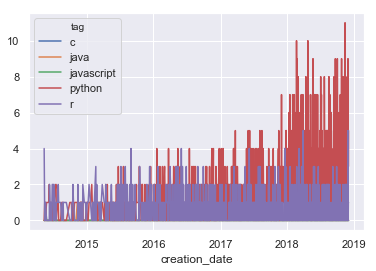

In [100]:
post_pivot_df.plot();

In [101]:
post_pivot_df.index = pd.DatetimeIndex(post_pivot_df.index)

In [104]:
tags_by_month = post_pivot_df.resample('MS').sum()
tags_by_month.head(10)

# weird!!  no c tagged question for 2014 may to 2015 ???

tag,c,java,javascript,python,r
creation_date,,,,,
2014-05-01,0.0,0.0,1.0,4.0,5.0
2014-06-01,0.0,0.0,1.0,8.0,5.0
2014-07-01,0.0,0.0,0.0,10.0,8.0
2014-08-01,0.0,0.0,0.0,4.0,11.0
2014-09-01,0.0,0.0,0.0,0.0,3.0
2014-10-01,0.0,1.0,0.0,5.0,7.0
2014-11-01,0.0,3.0,1.0,7.0,6.0
2014-12-01,0.0,2.0,1.0,5.0,9.0
2015-01-01,0.0,0.0,0.0,4.0,5.0


In [106]:
tags_by_month.loc[tags_by_month.c >0 ,:].head()

tag,c,java,javascript,python,r
creation_date,,,,,
2015-03-01,1.0,0.0,1.0,5.0,9.0
2015-12-01,1.0,1.0,0.0,21.0,20.0
2016-04-01,1.0,0.0,1.0,27.0,18.0
2017-02-01,1.0,3.0,0.0,31.0,9.0
2018-03-01,1.0,0.0,1.0,97.0,31.0


In [107]:
tags_by_month.loc[tags_by_month.javascript >0 ,:].head()

tag,c,java,javascript,python,r
creation_date,,,,,
2014-05-01,0.0,0.0,1.0,4.0,5.0
2014-06-01,0.0,0.0,1.0,8.0,5.0
2014-11-01,0.0,3.0,1.0,7.0,6.0
2014-12-01,0.0,2.0,1.0,5.0,9.0
2015-03-01,1.0,0.0,1.0,5.0,9.0


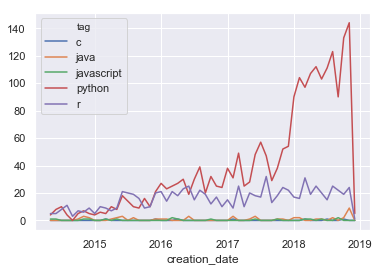

In [105]:
tags_by_month.plot();